<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Spatial_interpolation/deterministic_spatial_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deterministic Methods for Spatial Interpolation in R

Zia Ahmed, University at Buffalo

Deterministic methods for spatial interpolation are mathematical techniques that do not consider the statistical properties or random variations in the data. Instead, they rely on predefined mathematical functions or rules to estimate values at unmeasured locations based on the values of nearby data points. These methods are useful when you have a good understanding of the underlying spatial patterns and believe that the data can be accurately represented by deterministic relationships.

### Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314931 sha256=e610e986f34c3d89b59d19b20687f718ad31be779e9a730b5d6ca03f1e73ac4f
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Check and Install Required R Packages

In [ ]:
%%R
pkg <- c('tidyverse', 'raster', 'rgdal','terra','tidyterra', 'maptools', 'sf', 'classInt',
         'RColorBrewer', 'tmap','tmaptools', 'gridExtra', 'devtools', 'data.table', 'gstat','Hmisc','corrplot', 'ggmap','plyr')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Install 'spatstat', 'dismo', and 'fields'


In [ ]:
%%R
install.packages(c('spatstat','dismo','fields'), lib='drive/My Drive/R/')

### Load R Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library (tidyverse)
library (terra)
library (tidyterra)
library(raster)
library(RColorBrewer)
library(RStoolbox)
library(gridExtra)
library(latticeExtra)
library(data.table)
library(gstat)
library(classInt)
library(plyr)
library(spatstat)
library(dismo)
library(fields)

### Data

The following data will be used in the exercise that can be found [here](https://github.com/zia207/r-colab/tree/main/Data/Spatial_interpolation).

1. train_data.csv

2. GP_STATE.shp

3. GP_prediction_grid_data.csv

In [17]:
%%R
train<-read_csv('/content/drive/MyDrive/Data/Spatial_Interpolatiom/train_data.csv')
grid<-read_csv('/content/drive/MyDrive/Data/Spatial_Interpolatiom/GP_prediction_grid_data.csv')
state<-shapefile("/content/drive/MyDrive/Data/Spatial_Interpolatiom/GP_STATE.shp")

Rows: 368 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD_DES, FRG_DES
dbl (17): ID, STATE_ID, FIPS, x, y, SOC, ELEV, Aspect, Slope, TPI, K_Factor,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10674 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): x, y, Aspect, ELEV, FRG, K_Factor, MAP, MAT, NDVI, NLCD, Slit_Clay...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
%%R
glimpse(train)

Rows: 368
Columns: 21
$ ID        <dbl> 87, 52, 75, 55, 51, 77, 265, 82, 67, 188, 250, 224, 229, 164…
$ STATE_ID  <dbl> 35, 8, 35, 35, 8, 35, 35, 35, 35, 8, 35, 35, 8, 8, 35, 8, 8,…
$ STATE     <chr> "New Mexico", "Colorado", "New Mexico", "New Mexico", "Color…
$ FIPS      <dbl> 35003, 8033, 35003, 35031, 8033, 35006, 35015, 35003, 35003,…
$ COUNTY    <chr> "Catron County", "Dolores County", "Catron County", "McKinle…
$ x         <dbl> -1116586.5, -1107341.6, -1128512.3, -1137299.0, -1106344.8, …
$ y         <dbl> 1228025, 1699359, 1281006, 1446994, 1716869, 1419122, 105112…
$ SOC       <dbl> 1.333, 3.782, 3.393, 4.594, 5.995, 7.596, 10.276, 3.842, 11.…
$ ELEV      <dbl> 2192.513, 2328.449, 2357.302, 2261.782, 2404.112, 2514.776, …
$ Aspect    <dbl> 174.4923, 219.6880, 173.9527, 222.3785, 183.5729, 165.2028, …
$ Slope     <dbl> 8.080985, 10.462741, 8.016197, 4.874323, 6.680480, 6.598982,…
$ TPI       <dbl> -0.42157000, 0.55147684, -3.36669755, -1.44094825, 7.7656183…
$ K_Factor  <dbl> 

### Create prediction grid

In [18]:
%%R
p.grid<-grid[,1:2]
head(p.grid)

# A tibble: 6 × 2
         x       y
     <dbl>   <dbl>
1 -1185285 2533795
2 -1175285 2533795
3 -1165285 2533795
4 -1155285 2533795
5 -1145285 2533795
6 -1135285 2533795


In [19]:
%%R
coordinates(train) = ~x+y
coordinates(p.grid) = ~x+y
gridded(p.grid) <- TRUE

## Trend Surface Analysis

Trend Surface Analysis (TSA) is a Deterministic spatial interpolation and modeling method. It is particularly useful when you want to capture and describe the broad, systematic trends or patterns in a set of data points distributed across a geographic area. TSA fits a polynomial equation to the data points, allowing you to create a smooth surface that represents the general trend in the data.

Here are the key aspects of Trend Surface Analysis:

1. **Data Points**: TSA begins with a set of data points that represent measurements or observations across a geographic region. These data points can relate to various types of information, such as elevation, temperature, or any other variable that exhibits spatial variation.

2. **Polynomial Equation**: The core of TSA is fitting a polynomial equation to the data points. The polynomial equation represents a mathematical surface that approximates the trend or pattern observed in the data.

3. **Polynomial Degree**: The degree of the polynomial equation is a critical aspect of TSA. The choice of degree determines the complexity of the model and its ability to capture different types of trends.

4. **Coefficient Estimation**: To perform TSA, you need to estimate the coefficients (a, b, c, etc.) of the polynomial equation that best fits the data points. This is often done through a process of regression or least-squares estimation, where the goal is to minimize the error between the predicted values from the polynomial equation and the actual data points.

5. **Interpolation and Visualization**: Once you have determined the coefficients of the polynomial equation, you can use this equation to predict values at unmeasured locations within the geographic area. The result is a smooth, continuous surface that represents the general trend or pattern in the data. This surface can be visualized as a contour map, 3D surface, or other forms of spatial representation.

6. **Advantages and Limitations**:
   - Advantages of TSA include its simplicity, ability to capture and visualize general trends, and ease of interpretation.
   - Limitations include the potential inability to capture complex localized variations, as it focuses on broad trends, and it may not provide measures of uncertainty or error associated with predictions.

Trend Surface Analysis is commonly used in geology, geography, and various environmental sciences to model and understand large-scale spatial trends, such as elevation changes, temperature gradients, or population distribution. It's a valuable tool when you want to create a simple, smooth representation of data to identify overarching spatial patterns.

### Linear (First-Degree) Polynomial

A linear equation, represented as Z(x, y) = a + bx + cy, captures a simple trend that may involve a constant (a), a linear trend in the x direction (b), and a linear trend in the y direction (c).

We will use **krige()** function of **gstat** package without the geographic coordinates specified. It will perform ordinary or weighted least squares prediction:

In [ ]:
%%R
trend_1st<-krige(SOC ~ x + y, train, p.grid)
summary(trend_1st)

[ordinary or weighted least squares prediction]
Object of class SpatialPixelsDataFrame
Coordinates:
       min     max
x -1250285  119715
y   998795 2538795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Grid attributes:
  cellcentre.offset cellsize cells.dim
x          -1245285    10000       137
y           1003795    10000       154
Data attributes:
   var1.pred        var1.var    
 Min.   :2.814   Min.   :24.13  
 1st Qu.:5.153   1st Qu.:24.17  
 Median :6.549   Median :24.24  
 Mean   :6.316   Mean   :24.26  
 3rd Qu.:7.383   3rd Qu.:24.34  
 Max.   :9.251   Max.   :24.62  


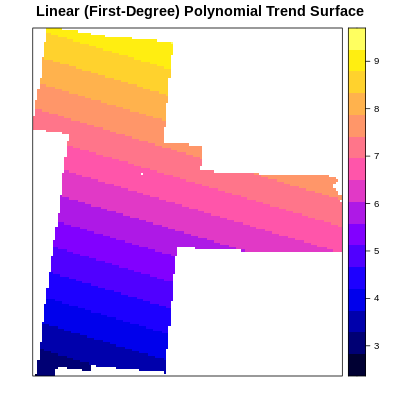

In [ ]:
%%R -w 400 -h 400 -u px
spplot(trend_1st ,"var1.pred",
       main= "Linear (First-Degree) Polynomial Trend Surface")

### Quadratic (Second-Degree) Polynomial

 A quadratic equation, such as Z(x, y) = a + bx + cy + dx^2 + exy + fy^2, can model more complex trends, including curvatures.

In [ ]:
%%R
trend_2nd<-krige(SOC ~ x + y + I(x*y) + I(x^2) + I(y^2), train, p.grid)
summary(trend_2nd)

[ordinary or weighted least squares prediction]
Object of class SpatialPixelsDataFrame
Coordinates:
       min     max
x -1250285  119715
y   998795 2538795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Grid attributes:
  cellcentre.offset cellsize cells.dim
x          -1245285    10000       137
y           1003795    10000       154
Data attributes:
   var1.pred          var1.var    
 Min.   : 0.5955   Min.   :22.04  
 1st Qu.: 5.1468   1st Qu.:22.09  
 Median : 6.1480   Median :22.17  
 Mean   : 6.2871   Mean   :22.28  
 3rd Qu.: 7.7320   3rd Qu.:22.39  
 Max.   :12.1479   Max.   :23.67  


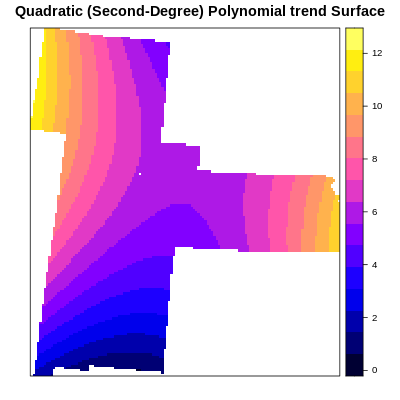

In [ ]:
%%R -w 400 -h 400 -u px
spplot(trend_2nd ,"var1.pred",
       main= "Quadratic (Second-Degree) Polynomial trend Surface")

### Cubic (Third-Degree) Polynomial:

A cubic equation adds terms for cubic trends, which can capture even more intricate spatial patterns.

In [ ]:
%%R
trend_3rd<-krige(SOC ~ x+y + x*y+I(x^2)+I(y^2) + I(x^3)+I(x^2*y)+I(x*y^2)+I(y^3), train, p.grid)
summary(trend_3rd)

[ordinary or weighted least squares prediction]
Object of class SpatialPixelsDataFrame
Coordinates:
       min     max
x -1250285  119715
y   998795 2538795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Grid attributes:
  cellcentre.offset cellsize cells.dim
x          -1245285    10000       137
y           1003795    10000       154
Data attributes:
   var1.pred         var1.var    
 Min.   :-1.178   Min.   :21.93  
 1st Qu.: 5.289   1st Qu.:22.01  
 Median : 6.150   Median :22.12  
 Mean   : 6.345   Mean   :22.33  
 3rd Qu.: 7.617   3rd Qu.:22.43  
 Max.   :13.402   Max.   :26.12  


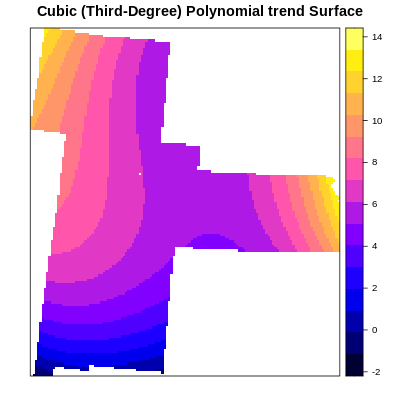

In [ ]:
%%R -w 400 -h 400 -u px
spplot(trend_3rd ,"var1.pred",
       main= "Cubic (Third-Degree) Polynomial trend Surface")

## Proximity Analysis-Thiessen Polygons

Proximity analysis using Thiessen polygons, also known as Voronoi polygons or Dirichlet polygons, is a spatial analysis method used in geographic information systems (GIS) and geography. It is a way to partition a geographic area into distinct regions based on the proximity of data points. The resulting polygons are called Thiessen polygons or Voronoi polygons. Here's how the process works:

1. **Data Points**: The method begins with a set of data points, each of which has specific geographic coordinates. These data points could represent, for example, weather stations, healthcare facilities, or any other location-based data.

2. **Polygon Creation**: Thiessen polygons are constructed by connecting the lines (or edges) that are equidistant between adjacent data points. In other words, each polygon is defined as the area that is closer to one specific data point than to any other data point.

3. **Proximity Principle**: The fundamental principle behind Thiessen polygons is the "proximity principle." This means that any location within a Thiessen polygon is closer to the central data point of that polygon than to any other data point.

4. **Polygon Shape**: The shape of the Thiessen polygons depends on the spatial distribution of data points. If the data points are close together, the resulting polygons will be smaller and more irregular. If the data points are spread out, the polygons will be larger and simpler.

5. **Use Cases**:
   - **Spatial Analysis**: Thiessen polygons are useful for spatial analysis, as they can help determine which data point is closest to any given location within the study area.
   - **Resource Allocation**: In applications such as emergency services or facility location analysis, Thiessen polygons are used to determine which facilities or services are closest to specific locations.
   - **Hydrology**: Thiessen polygons are also used in hydrology to delineate watersheds. Each watershed is represented by a Thiessen polygon, with the high point (the point that drains to that location) being the data point.

6. **Mathematical Calculation**: To create Thiessen polygons, the distances from each data point to all other data points are calculated. The polygon edges are defined by the perpendicular bisectors of the line segments connecting each data point to its neighbors.

7. **Visualization**: Thiessen polygons are commonly visualized on maps, and they are often shaded or colored based on the values associated with the data points (e.g., rainfall amounts, population density) to indicate spatial patterns.

Thiessen polygons are a simple and intuitive way to perform proximity analysis and are often used when you need to assign locations to the nearest known data points. However, they have limitations. For example, they assume a Euclidean (straight-line) distance metric and may not be appropriate for certain types of data distributions. In cases where the data points are not well-distributed, other interpolation methods, like Inverse Distance Weighting or Kriging, may be more suitable for estimating values between data points.

The Thiessen polygons can be created using **dirichlet()** function of **spatstat** or **voronoi()** function of **dismo** package in R

Here, we will apply voronoi function of dismo package. Before creating thiessen polygons, we have to create a SpatialPointsDataFrame

In [9]:
%%R
df<-as.data.frame(train) %>%
dplyr::select(x,y,SOC) %>%
glimpse()

Rows: 368
Columns: 3
$ x   <dbl> -1116586.5, -1107341.6, -1128512.3, -1137299.0, -1106344.8, -11061…
$ y   <dbl> 1228025, 1699359, 1281006, 1446994, 1716869, 1419122, 1051129, 123…
$ SOC <dbl> 1.333, 3.782, 3.393, 4.594, 5.995, 7.596, 10.276, 3.842, 11.220, 2…


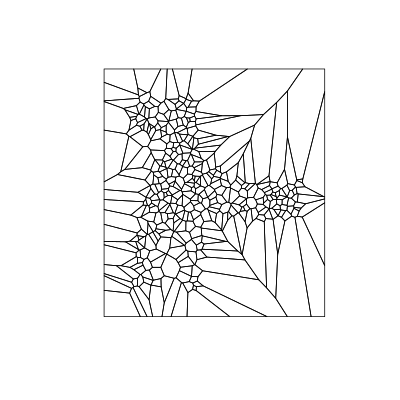

In [10]:
%%R -w 400 -h 400 -u px
##  define coordinates
xy <- df[,1:2]
# Convert to spatial point
SPDF <- SpatialPointsDataFrame(coords = xy, data=df)
v <- voronoi(SPDF)
plot(v)

In [11]:
%%R
# disslove inter-state boundary
bd <- aggregate(state)
# apply intersect fuction to clip
v.gp <- raster::intersect(v, bd)


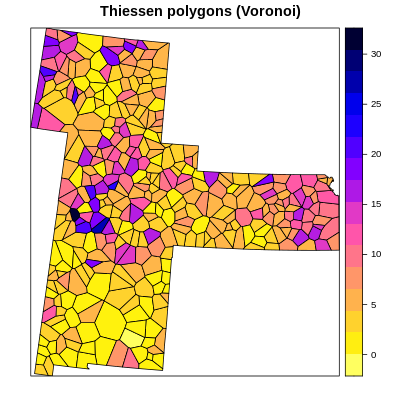

In [12]:
%%R -w 400 -h 400 -u px
spplot(v.gp, 'SOC',
       main= "Thiessen polygons (Voronoi)",
       col.regions=rev(get_col_regions()))

Now will convert this Voronoi polygon to raster (10 km x 10 km)

In [13]:
%%R
r <- raster(bd, res=10000)
vr <- rasterize(v.gp, r, 'SOC')

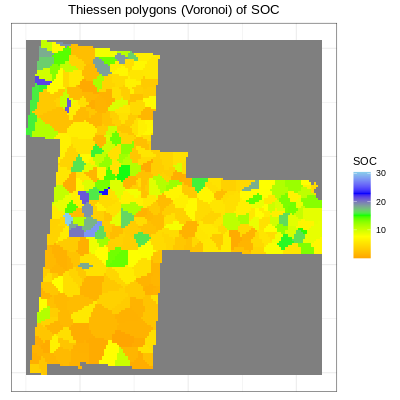

In [14]:
%%R -w 400 -h 400 -u px
ggR(vr, geom_raster = TRUE) +
  scale_fill_gradientn("SOC", colours = c("orange", "yellow", "green",  "blue","sky blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("Thiessen polygons (Voronoi) of SOC")+
   theme(plot.title = element_text(hjust = 0.5))

## Nearest Neighbor Interpolation

Nearest neighbor interpolation is a simple and straightforward spatial interpolation method used in geographic information systems (GIS) and other applications to estimate values at unmeasured locations based on the values of the nearest data points. This method is often used when you want to assign the value of the closest known data point to a specific location. Here's how nearest neighbor interpolation works:

1. **Data Points**: The process begins with a set of data points, each of which has specific geographic coordinates and associated values. These data points could represent, for example, temperature measurements at weather stations or population counts at census locations.

2. **Unmeasured Locations**: Nearest neighbor interpolation is applied to unmeasured or target locations for which you want to estimate values. These locations are typically specified by their coordinates (e.g., latitude and longitude).

3. **Nearest Neighbor Search**: For each unmeasured location, the method calculates the distance to all the data points and identifies the closest data point. The nearest neighbor is determined by using a distance metric, such as Euclidean distance (straight-line distance) in a two-dimensional space.

4. **Value Assignment**: The value of the nearest data point is assigned to the unmeasured location as the estimated value. This means that the unmeasured location inherits the value of the closest known data point.

5. **Example**: For instance, if you have a map of weather stations with temperature measurements, and you want to estimate the temperature at a specific location in between those stations, nearest neighbor interpolation will assign the temperature from the nearest weather station as the estimate for that location.

6. **Advantages**:
   - Nearest neighbor interpolation is simple and computationally efficient.
   - It preserves the actual data values and does not alter them.

7. **Limitations**:
   - This method can result in abrupt changes or "staircase" patterns in the interpolated surface, which may not accurately reflect the actual spatial variation.
   - It does not take into account the values of other nearby data points, leading to less smooth or less accurate estimates, especially if the data points are not well-distributed.
   - It may not be suitable for continuous variables, as it does not provide a smooth transition between neighboring points.

Nearest neighbor interpolation is a useful tool when the data points are sparse and you want a quick and straightforward way to estimate values at unmeasured locations. However, it may not be the best choice when you require a more continuous or smooth representation of the data, and in such cases, other interpolation methods like inverse distance weighting, spline interpolation, or kriging may be more appropriate.

We will use **krige()** function og **gstat** package to interpolate SOC using five Nearest Neighbor. First we fit a model ( ~1 means) “intercept only” using **krige()** function. In the case of spatial data, that would be only ‘x’ and ‘y’ coordinates are used. We set the maximum number of points to 5, and the “inverse distance power” (idp) to zero, such that all five neighbors are equally weighted.

In [ ]:
%%R
coordinates(train) = ~x+y
coordinates(p.grid) = ~x+y
gridded(p.grid) <- TRUE

In [ ]:
%%R
nn <- krige(SOC ~ 1, train, p.grid, nmax=5, set=list(idp = 0))
# convert to raster
nn.na<-na.omit(nn)
nn.pred<-rasterFromXYZ(as.data.frame(nn)[, c("x", "y", "var1.pred")])

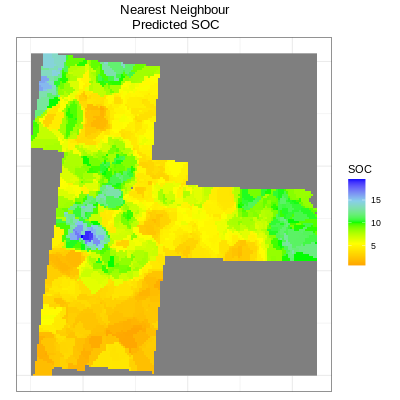

In [19]:
%%R -w 400 -h 400 -u px
ggR(nn.pred, geom_raster = TRUE) +
  scale_fill_gradientn("SOC", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("Nearest Neighbour\n Predicted SOC")+
   theme(plot.title = element_text(hjust = 0.5))

## Thin Plate Spline

A Thin Plate Spline (TPS) is a mathematical function used for surface interpolation and approximation in the field of spatial analysis and computational geometry. Thin Plate Splines are particularly useful when you need to create a smooth, continuous surface that passes through a set of scattered data points. They are often used in geographic information systems (GIS), remote sensing, and various applications in which spatial modeling and interpolation are important.

Here are the key characteristics and components of Thin Plate Splines:

1. **Data Points**: TPS interpolation begins with a set of scattered data points. These data points have coordinates in space and are associated with specific values, such as elevation, temperature, or any other continuous variable. The goal is to create a surface that best represents the data while being as smooth as possible.

2. **Mathematical Function**: The Thin Plate Spline is a radial basis function that is used to approximate the surface. The function for 2D data is often expressed as follows:

   ```
   S(x, y) = a + bx + cy + Σw_i * ϕ(‖P_i - (x, y)‖)
   ```

   - `S(x, y)` is the estimated surface value at a given point `(x, y)`.
   - `a`, `b`, and `c` are coefficients that are determined during the interpolation process.
   - `Σ` represents the summation over all data points `P_i`.
   - `w_i` are weights that are also determined during interpolation.
   - `ϕ(‖P_i - (x, y)‖)` is a radial basis function, typically defined as `‖P_i - (x, y)‖^2 * log(‖P_i - (x, y)‖)`.

3. **Smoothness Constraint**: The key characteristic of Thin Plate Spline is that it enforces a smoothness constraint on the resulting surface. This means that the surface will be smooth and minimize bending energy. It aims to create the most "natural" and smooth surface while fitting the data.

4. **Coefficient Estimation**: To use TPS for interpolation, you must estimate the coefficients `a`, `b`, `c`, and the weights `w_i`. This is often done through a process called radial basis function interpolation or through linear algebra techniques. These coefficients and weights ensure that the spline closely approximates the data points and maintains smoothness.

5. **Applications**: Thin Plate Splines are used in various fields, including GIS, image processing, terrain modeling, medical imaging, and computer graphics. They are particularly useful when you want to create continuous surfaces from sparse data points while maintaining a high degree of smoothness.

6. **Advantages**: TPS provides a flexible way to interpolate data and create smooth surfaces. It can handle irregularly spaced data points and adapt well to complex spatial variations.

7. **Limitations**: TPS can be computationally expensive for large datasets. Also, it may not be the best choice for surfaces with abrupt changes or discontinuities.

Thin Plate Splines offer a valuable tool for spatial interpolation, especially when you need to create continuous surfaces that capture the underlying patterns and smooth variations in your data.

We use **Tps()** function of **field** package to create thin plate spline surface

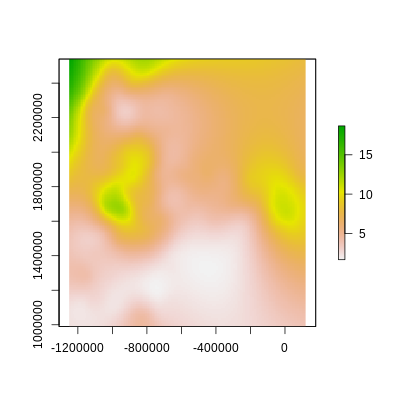

In [20]:
%%R -w 400 -h 400 -u px
m <- Tps(coordinates(train), train$SOC)
tps <- interpolate(r, m)
plot(tps)

In [22]:
%%R
tps <- raster::mask(tps,bd) # mask out

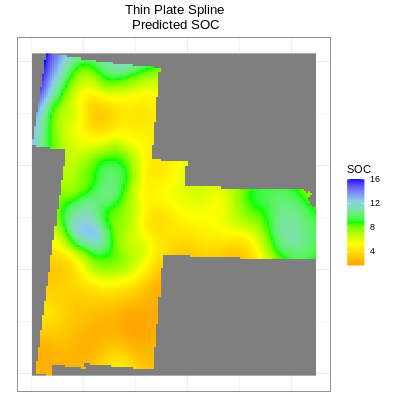

In [23]:
%%R -w 400 -h 400 -u px
ggR(tps, geom_raster = TRUE) +
  scale_fill_gradientn("SOC", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("Thin Plate Spline\n Predicted SOC")+
   theme(plot.title = element_text(hjust = 0.5))

## Inverse Distance Weighted Interpolation

Inverse Distance Weighted (IDW) interpolation is a spatial analysis method used to estimate values at unmeasured locations based on the values of nearby data points. It is a deterministic interpolation technique that assigns a weighted average of known data values to each unmeasured location. The weights decrease as the distance between the unmeasured location and the data points increases, reflecting the principle that closer data points have a stronger influence on the estimated value. Here's how the Inverse Distance Weighted interpolation method works:

1. **Data Points**: The process begins with a set of data points, each of which has specific geographic coordinates and associated values. These data points could represent measurements of variables like elevation, temperature, air quality, or any other continuous or discrete variable.

2. **Unmeasured Locations**: In IDW, you have one or more unmeasured locations for which you want to estimate values. These locations are typically specified by their coordinates (e.g., latitude and longitude) and do not have associated values.

3. **Distance Calculation**: IDW calculates the distance between each unmeasured location and all the data points. The most commonly used distance metric is Euclidean distance (straight-line distance) in a two-dimensional or three-dimensional space.

4. **Weighting**: The weight assigned to each data point for a specific unmeasured location is inversely proportional to the distance between the unmeasured location and the data point. The formula for the weight (w_i) of a data point (Z_i) is typically expressed as:

   ```
   w_i = 1 / (d_i^p)
   ```

   - `w_i` is the weight of the data point.
   - `d_i` is the distance between the unmeasured location and the data point.
   - `p` is a user-defined exponent that controls the rate at which the influence of data points decreases with distance. Common choices for p include 1 (inverse linear weighting), 2 (inverse square weighting), and higher values (which give more weight to the closest data points).

5. **Weighted Average**: The estimated value at the unmeasured location is calculated as the weighted average of the values associated with the nearby data points, using the calculated weights. The formula for the estimated value (Z_est) at an unmeasured location is typically expressed as:

   ```
   Z_est = Σ (w_i * Z_i) / Σ w_i
   ```

   - `Z_est` is the estimated value at the unmeasured location.
   - `Σ` represents the summation over all data points.
   - `w_i` is the weight of each data point.
   - `Z_i` is the known value associated with each data point.

6. **Applications**: IDW interpolation is widely used in fields such as geostatistics, environmental science, and geographic information systems (GIS). It is applied to create continuous surfaces or maps of various environmental variables like terrain elevation, temperature, rainfall, pollution levels, and more.

IDW is a simple and intuitive method for spatial interpolation, especially when you want to create continuous surfaces from sparse or irregularly spaced data points. However, the choice of the distance decay exponent (p) significantly influences the results, and the method assumes a certain degree of spatial continuity that may not be appropriate in all cases.

We will use **krige()** function of the gstat package to interpolate SOC using IDW. First we fit a model ( ~1 means) “intercept only” using krige() function. In the case of spatial data, that would be only ‘x’ and ‘y’ coordinates are used

In [29]:
%%R
# power = 2
IDW.2<- krige(SOC ~ 1, train, p.grid, set=list(idp = 2))
# power = 4
IDW.4<- krige(SOC ~ 1, train, p.grid, set=list(idp = 4))
# power = 6
IDW.6<- krige(SOC ~ 1, train, p.grid, set=list(idp = 6))

[inverse distance weighted interpolation]
[inverse distance weighted interpolation]
[inverse distance weighted interpolation]


In [30]:
%%R
# Clean up
idw.output.2 = as.data.frame(IDW.2)
idw.output.4 = as.data.frame(IDW.4)
idw.output.6 = as.data.frame(IDW.6)
# rename
names(idw.output.2)[1:3] <- c("x", "y", "SOC")
names(idw.output.4)[1:3] <- c("x", "y", "SOC")
names(idw.output.6)[1:3] <- c("x", "y", "SOC")

train.df<-as.data.frame(train)

In [54]:
%%R

# Power 2
p2 <- ggplot() +
  geom_tile(data = idw.output.2, aes(x = x, y = y, fill = SOC)) +
  geom_point(data = train.df, aes(x = x, y = y, size = SOC), shape = 21, colour = "grey") +
  scale_fill_gradientn("Predicted SOC", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  scale_size_continuous(name = "Observed SOC", range = c(1, 6)) +
  theme_bw() +
  scale_x_continuous(expand = c(0, 0)) +
  scale_y_continuous(expand = c(0, 0)) +
  theme(axis.text.y = element_text(angle = 90)) +
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)))+
     ggtitle("Inverse Distance Weighted (IDW), p=2\n Predicted SOC")+
   theme(plot.title = element_text(hjust = 0.5))

# Power 4
p4 <- ggplot() +
  geom_tile(data = idw.output.4, aes(x = x, y = y, fill = SOC)) +
  geom_point(data = train.df, aes(x = x, y = y, size = SOC), shape = 21, colour = "grey") +
  scale_fill_gradientn("Predicted SOC", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  scale_size_continuous(name = "Observed SOC", range = c(1, 6)) +
  theme_bw() +
  scale_x_continuous(expand = c(0, 0)) +
  scale_y_continuous(expand = c(0, 0)) +
  theme(axis.text.y = element_text(angle = 90)) +
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)))+
     ggtitle("Inverse Distance Weighted (IDW), p=4\n Predicted SOC")+
   theme(plot.title = element_text(hjust = 0.5))

# Power 6
p6 <- ggplot() +
  geom_tile(data = idw.output.6, aes(x = x, y = y, fill = SOC)) +
  geom_point(data = train.df, aes(x = x, y = y, size = SOC), shape = 21, colour = "grey") +
  scale_fill_gradientn("Predicted SOC", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
 scale_size_continuous(name = "Observed SOC", range = c(1, 6)) +
  theme_bw() +
  scale_x_continuous(expand = c(0, 0)) +
  scale_y_continuous(expand = c(0, 0)) +
  theme(axis.text.y = element_text(angle = 90)) +
  theme(axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)))+
     ggtitle("Inverse Distance Weighted (IDW), p=6\n Predicted SOC")+
   theme(plot.title = element_text(hjust = 0.5))



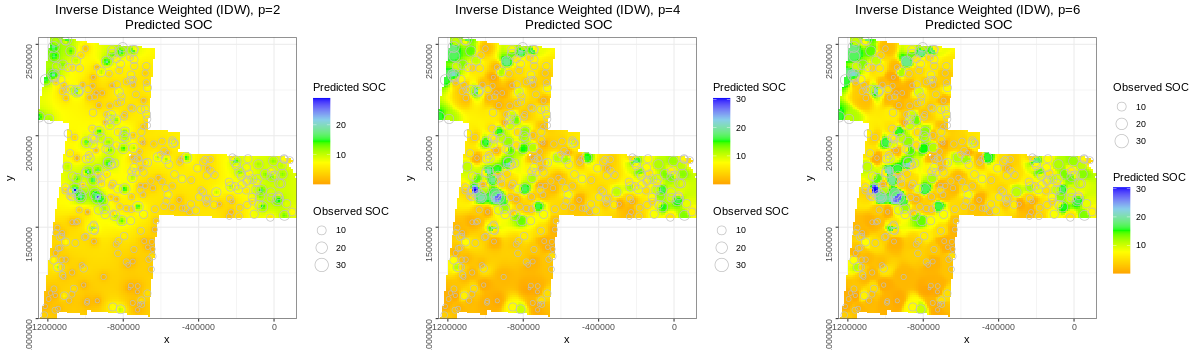

In [55]:
%%R -w 1200 -h 350 -u px
grid.arrange(p2, p4, p6, ncol=3)

### Further Reading

1. [Deterministic methods for spatial interpolation](https://pro.arcgis.com/en/pro-app/latest/help/analysis/geostatistical-analyst/deterministic-methods-for-spatial-interpolation.htm)

2. [Spatial Interpolation Methods](https://iri.columbia.edu/~rijaf/CDTUserGuide/html/interpolation_methods.html)

3. [Chapter 14 Spatial Interpolation](https://mgimond.github.io/Spatial/spatial-interpolation.html#spatial-interpolation)